This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os
import json

from src_python.mutation_filter import MutationFilter
from src_python.cell_tree import CellTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, create_mutation_matrix, \
    create_genotype_matrix, mut_count_distance

In [2]:
path = "../data/simulated_data"

n_cells = [50, 100, 100]
n_mut = [100, 100, 50]
n_tests = 100
clones = ["5", "10", "20", ""]
stratified = ""  # "_stratified" # stratified means all clones are about equally large

use_summary_statistics = False #True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False
genotype_differences = {"SCITE-RNA": {}}
path_len_differences = {"SCITE-RNA": {}}
likelihood_differences = {"SCITE-RNA": {}}
mut_count_differences = {"SCITE-RNA": {}}

In [ ]:
0.048104999999999995  mean abs difference of vafs predicted
24.639706122448978  mean path length distance
303.1213795918367  mean mutation count distance
0.047387000000000006  mean abs difference of vafs predicted
20.102514285714282  mean path length distance
200.96820408163268  mean mutation count distance
0.051969000000000015  mean abs difference of vafs predicted
18.218220408163262  mean path length distance
175.24928163265304  mean mutation count distance
0.034495  mean abs difference of vafs predicted
20.5288  mean path length distance
37.06448163265306  mean mutation count distance
0.0296855  mean abs difference of vafs predicted
50.25034141414141  mean path length distance
180.8878080808081  mean mutation count distance
0.029204000000000004  mean abs difference of vafs predicted
41.21997373737373  mean path length distance
108.45957575757576  mean mutation count distance
0.030486  mean abs difference of vafs predicted
38.955000000000005  mean path length distance
81.84896969696969  mean mutation count distance
0.022289500000000004  mean abs difference of vafs predicted
34.57913939393939  mean path length distance
14.324385858585861  mean mutation count distance
0.034884  mean abs difference of vafs predicted
44.22477979797981  mean path length distance
53.62284040404042  mean mutation count distance
0.032  mean abs difference of vafs predicted
40.42353535353536  mean path length distance
27.63507474747475  mean mutation count distance
0.033213  mean abs difference of vafs predicted
38.58487272727273  mean path length distance
20.226345454545456  mean mutation count distance
0.024310000000000002  mean abs difference of vafs predicted
40.22374343434343  mean path length distance


In [21]:
n_round = 0

config = load_config_and_set_random_seed()

mf = MutationFilter(error_rate=config["error_rate"], overdispersion=config["overdispersion"],
                                    genotype_freq=config["genotype_freq"], mut_freq=config["mut_freq"],
                                    dropout_alpha=config["dropout_alpha"], dropout_beta=config["dropout_beta"],
                                    dropout_direction_prob=config["dropout_direction"],
                                    overdispersion_h=config["overdispersion_h"])

if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(gt)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # flipped = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_flipped", f"sciterna_flipped_{n_round}r{t}.txt"), dtype=float)
                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)
                # mut_location = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_mutation_location", f"sciterna_mutation_location_{n_round}r{t}.txt"), dtype=int)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_sciterna = CellTree(n_c)
                # ct_sciterna.fit_llh(llh_1, llh_2)
                #
                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.flipped = flipped
                # ct_gt.mut_loc = mut_location
                # # ct_gt.update_all()
                #
                ct_sciterna.use_parent_vec(sciterna_parent_vec)
                # ct_sciterna.update_all()

                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                # mut_matrix = create_mutation_matrix(sciterna_parent_vec, ct_sciterna.mut_loc, ct_sciterna)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sciterna.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)
                #
                # differences.append(np.mean(np.abs(genotype_matrix - genotype_gt)))

                # likelihoods.append((ct_sciterna.joint - ct_gt.joint) / (ct_sciterna.n_cells * ct_sciterna.n_mut))

                # graph_gt = ct_gt.to_graphviz()
                # graph_sciterna = ct_sciterna.to_graphviz()
                # graph_gt.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_gt_{t}.png"), format='png', cleanup=True)
                # graph_sciterna.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_sciterna_{n_round}r{t}.png"), format='png', cleanup=True)
                # llr = llh_2 - llh_1
                # print("llr", n_round)

            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.047764  mean abs difference of vafs predicted
25.21418775510204  mean path length distance
305.3739428571428  mean mutation count distance
0.047623  mean abs difference of vafs predicted
20.39086530612245  mean path length distance
201.76449795918373  mean mutation count distance
0.051962  mean abs difference of vafs predicted
19.735085714285717  mean path length distance
173.66197551020406  mean mutation count distance
0.03448500000000001  mean abs difference of vafs predicted
20.67330612244898  mean path length distance
36.450816326530614  mean mutation count distance
0.030355  mean abs difference of vafs predicted
46.642375757575756  mean path length distance
184.9326909090909  mean mutation count distance
0.0296045  mean abs difference of vafs predicted
40.40786464646464  mean path length distance
110.58284646464648  mean mutation count distance
0.030955999999999997  mean abs difference of vafs predicted
35.10209696969697  mean path length distance
83.68591111111111  mean mutatio

In [23]:
genotype_differences["SClineager"] = {}
path_len_differences["SClineager"] = {}
likelihood_differences["SClineager"] = {}
mut_count_differences["SClineager"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                vaf_pred_path = os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
        
                vaf_pred = np.loadtxt(vaf_pred_path, dtype=float)

                if vaf_pred.shape != (n_c, n_m):
                    print("Variants were filtered out, skipping this test")
                    continue
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)
                
                genotype_predicted = np.round(vaf_pred * 2) / 2
                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_sclineager = CellTree(n_c)
                # ct_sclineager.fit_llh(llh_1, llh_2)
                #
                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.update_all()
                #
                ct_sclineager.use_parent_vec(sclineager_parent_vec)
                # ct_sclineager.update_all()
                #
                # mut_matrix = create_mutation_matrix(sclineager_parent_vec, ct_sclineager.mut_loc, ct_sclineager)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sclineager.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)

                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                # path_len_distances.append(mut_count_distance(genotype_gt, genotype_matrix))
                # differences.append(np.mean(np.abs(genotype_matrix - genotype_gt)))

                # likelihoods.append((ct_sclineager.joint - ct_gt.joint) / (ct_sclineager.n_cells * ct_sclineager.n_mut))

            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SClineager"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.08047899999999998  mean abs difference of vafs predicted
20.45032653061224  mean path length distance
nan  mean likelihood difference
257.0868163265306  mean mutation count distance


C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Variants were filtered out, skipping this test
0.08592323232323233  mean abs difference of vafs predicted
20.421158524015667  mean path length distance
nan  mean likelihood difference
159.5883240568955  mean mutation count distance
0.09730599999999999  mean abs difference of vafs predicted
21.024946938775507  mean path length distance
nan  mean likelihood difference
141.49459591836737  mean mutation count distance
0.070122  mean abs difference of vafs predicted
21.155200000000004  mean path length distance
nan  mean likelihood difference
85.51477551020409  mean mutation count distance
0.06883599999999998  mean abs difference of vafs predicted
27.125064646464644  mean path length distance
nan  mean likelihood difference
237.3891494949495  mean mutation count distance
0.06637449999999999  mean abs difference of vafs predicted
26.659957575757577  mean path length distance
nan  mean likelihood difference
149.29824242424243  mean mutation count distance
0.06770200000000001  mean abs differe

In [24]:
genotype_differences["DENDRO"] = {}
path_len_differences["DENDRO"] = {}
likelihood_differences["DENDRO"] = {}
mut_count_differences["DENDRO"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue

                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)
        
                gt = np.loadtxt(genotype_path, dtype=str).T
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)
                
                unique_classes = np.unique(clones_pred)
        
                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)
                    
                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")
                    
                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))
                        
                    
                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")
                
                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_dendro = CellTree(n_c)
                # ct_dendro.fit_llh(llh_1, llh_2)

                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.update_all()

                ct_dendro.use_parent_vec(dendro_parent_vec)
                # ct_dendro.update_all()

                # mut_matrix = create_mutation_matrix(dendro_parent_vec, ct_dendro.mut_loc, ct_dendro)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_dendro.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                # path_len_distances.append(mut_count_distance(genotype_gt, genotype_matrix.T))
                # differences.append(np.mean(np.abs(genotype_matrix.T - genotype_gt)))
                # likelihoods.append((ct_dendro.joint - ct_gt.joint) / (ct_dendro.n_cells * ct_dendro.n_mut))

                    
            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.09094100000000001  mean abs difference of vafs predicted
19.733820408163265  mean path length distance
82.01516161616162  mean mutation count distance
0.111477  mean abs difference of vafs predicted
19.579665306122443  mean path length distance
89.75331717171721  mean mutation count distance
0.11888300000000002  mean abs difference of vafs predicted
20.37288163265306  mean path length distance
91.85904848484846  mean mutation count distance
0.064331  mean abs difference of vafs predicted
19.750073469387758  mean path length distance
41.756779797979796  mean mutation count distance
0.05358  mean abs difference of vafs predicted
26.57198787878788  mean path length distance
150.89136161616162  mean mutation count distance
0.07538249999999999  mean abs difference of vafs predicted
25.71938585858586  mean path length distance
210.3250303030303  mean mutation count distance
0.09053499999999998  mean abs difference of vafs predicted
27.147080808080805  mean path length distance
259.51261212

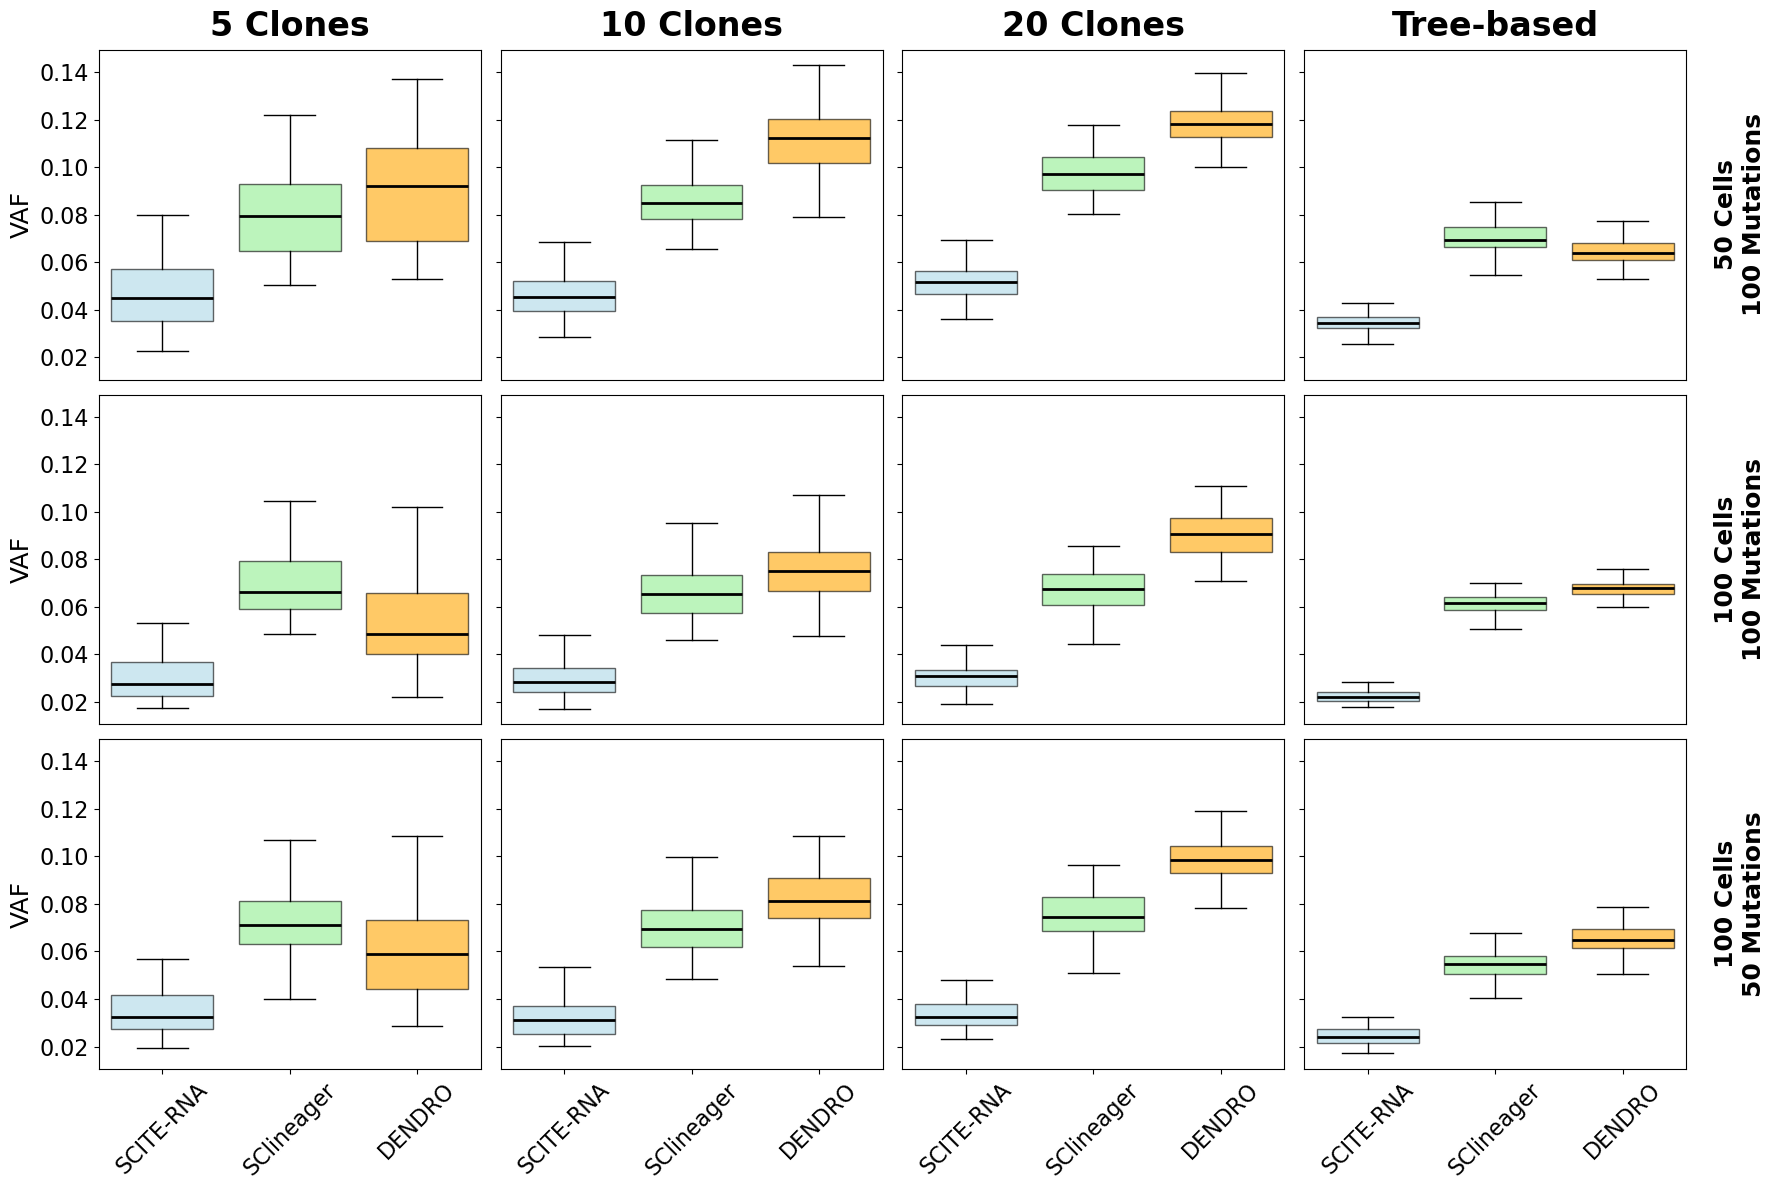

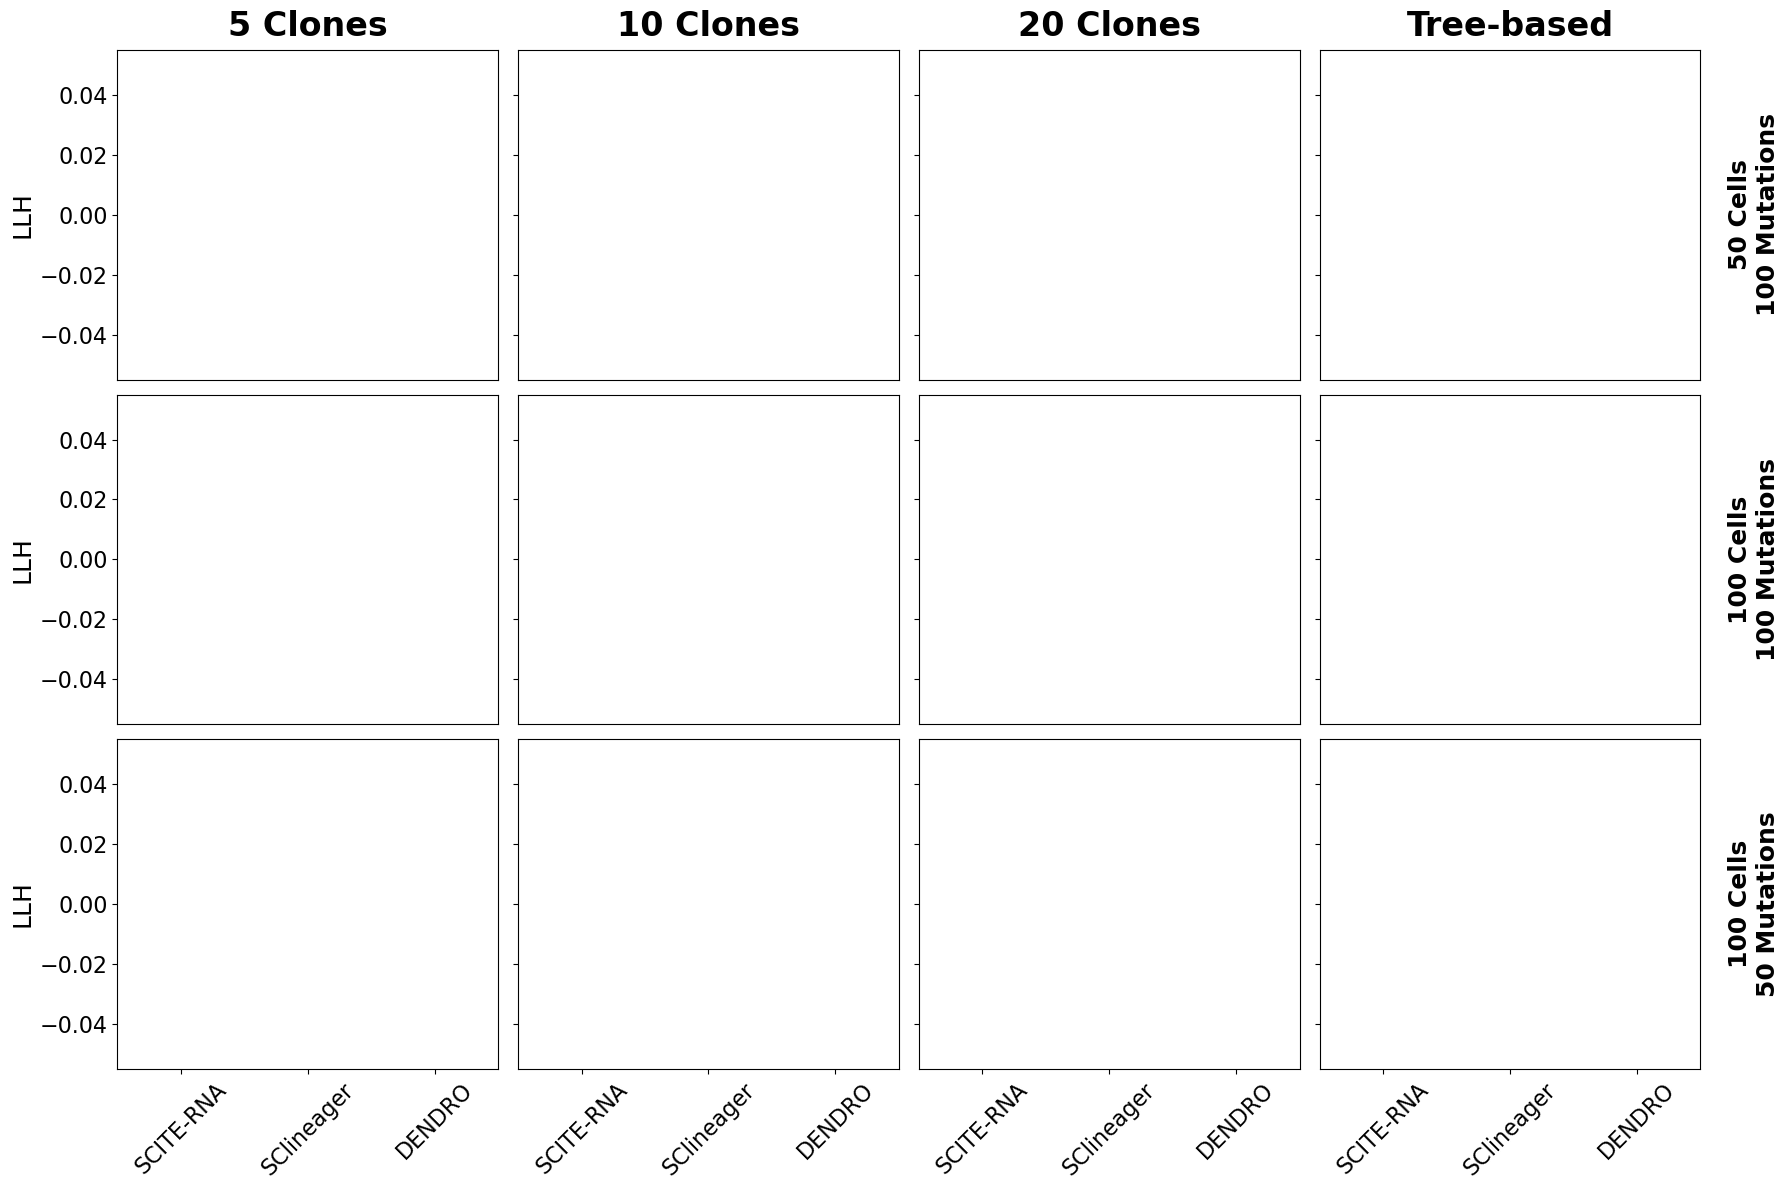

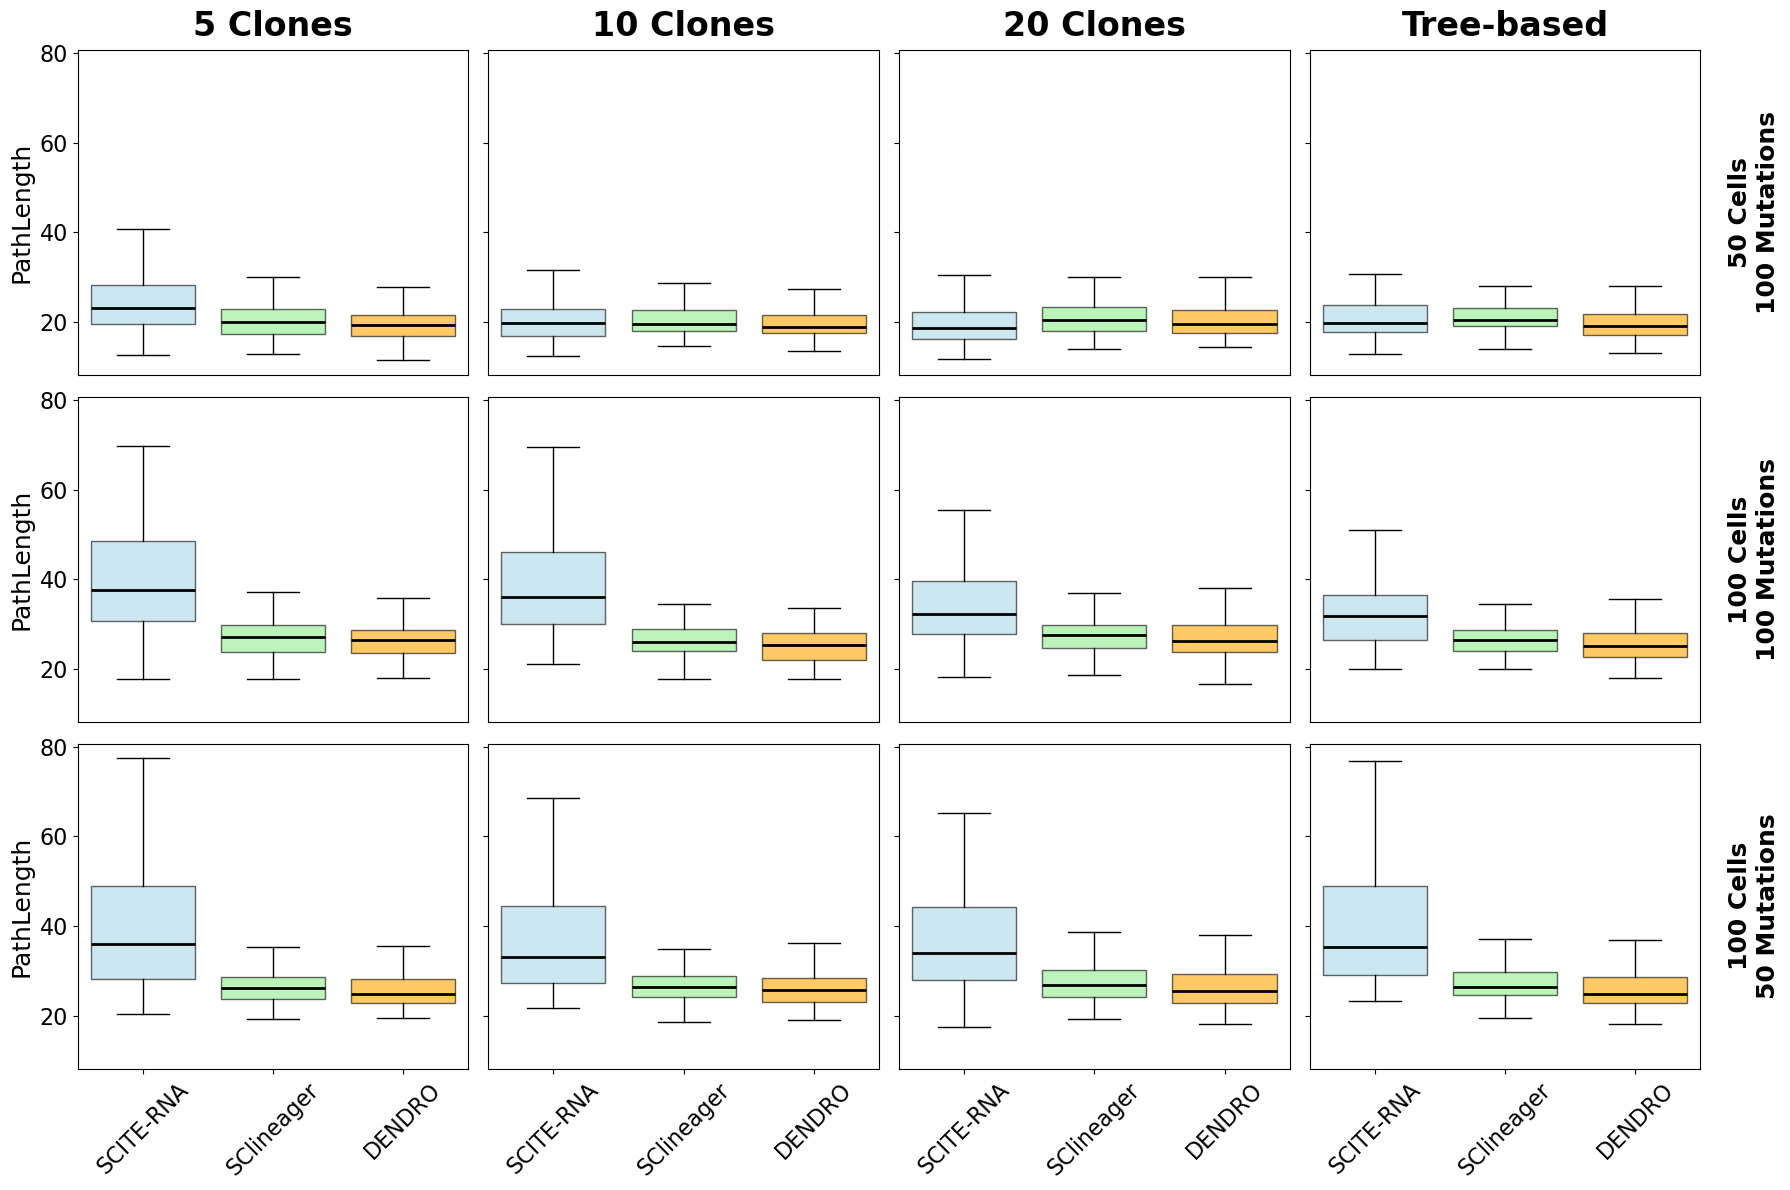

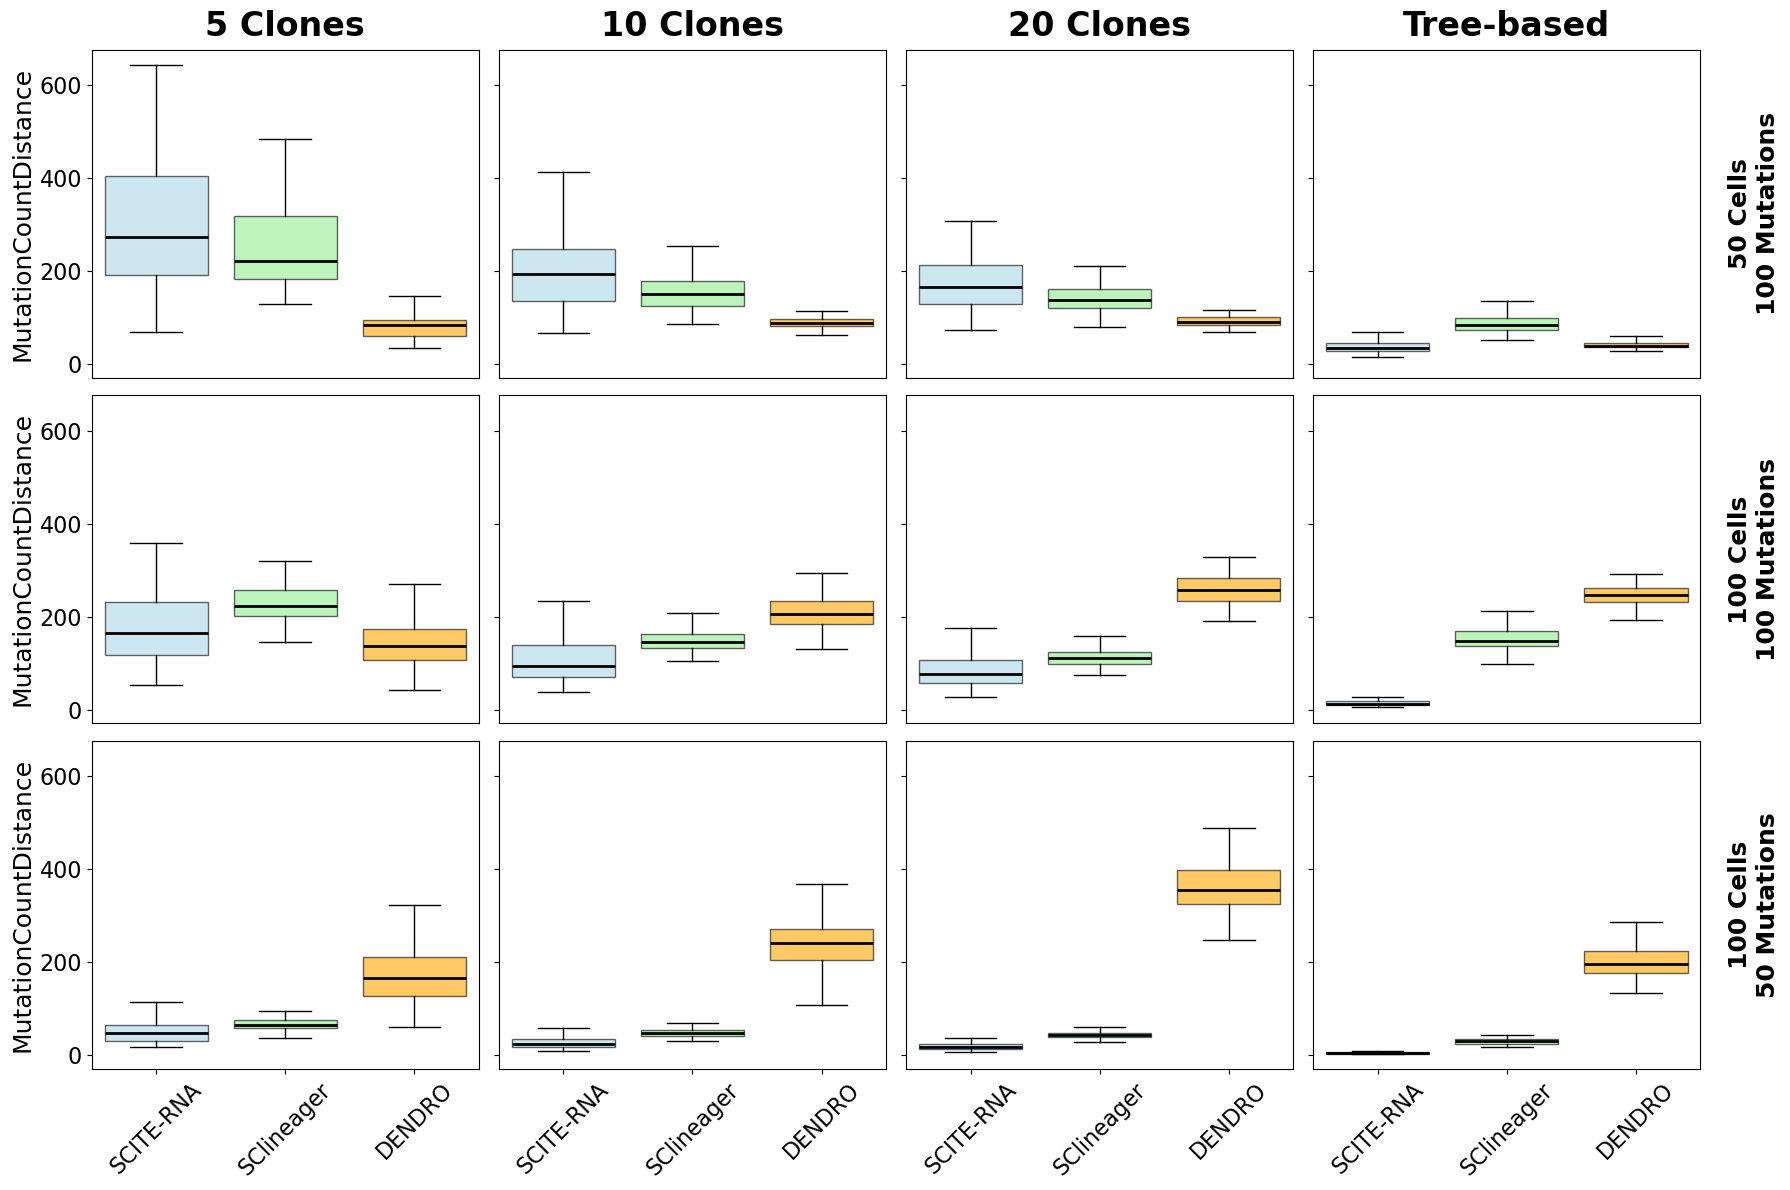

In [25]:
if use_summary_statistics:
    with open(r"../data/simulated_data/model_comparison.json") as f:
        genotype_differences = json.load(f)

def plot_results(results_data, title=""):
    models = ["SCITE-RNA", "SClineager", "DENDRO"]

    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharey=True)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 24
    label_size = 18
    tick_size = 16
    box_width = 2.0
    boxplot_widths = 0.8

    for row_idx, (n_c, n_m) in enumerate(zip(n_cells, n_mut)):
        for col_idx, clone in enumerate(clones):
            all_samples = []
            for model in models:
                all_samples.append(results_data[model][f"{n_c}_{n_m}"][clone])
                # all_samples.append(path_len_differences[model][f"{n_c}_{n_m}"][clone])
                # all_samples.append(likelihood_differences[model][f"{n_c}_{n_m}"][clone])

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            if row_idx == 0:
                if clone == "":
                    ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == 2:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])  # Remove x-ticks for the higher rows

            if col_idx == 0:
                ax.set_ylabel(f'{title}', fontsize=label_size)
            if col_idx == 3:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f'{n_c} Cells\n{n_m} Mutations', fontsize=label_size, rotation=90, labelpad=20, fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)

    plt.tight_layout()
    plt.savefig(f"../data/results/figures/clones_{title}.png")
    plt.show()

plot_results(genotype_differences, "VAF")
plot_results(likelihood_differences, "LLH")
plot_results(path_len_differences, "PathLength")
plot_results(mut_count_differences, "MutationCountDistance")

In [25]:
base_path = os.path.join(path, f"{100}c{100}m{10}{stratified}")

runtime_sclineager = np.loadtxt(os.path.join(base_path, "execution_times_sclineager.txt"))
runtime_dendro = np.loadtxt(os.path.join(base_path, "execution_times_dendro.txt"))
runtime_sciterna = np.loadtxt(os.path.join(base_path, "execution_times_sciterna.txt"))

data = [runtime_sciterna, runtime_sclineager, runtime_dendro]

plt.figure(figsize=(8, 5))
box = plt.boxplot(data, patch_artist=True, widths=boxplot_widths, showfliers=False)

colors = ["lightblue", "lightgreen", "orange"]
alpha_value = 0.6
box_width = 2.0

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(alpha_value)

for line in box['medians']:
    line.set_linewidth(box_width)
    line.set_color("black")

plt.title("Runtime Comparison (100 Cells, 100 Mutations)", fontsize=24, pad=20)
plt.ylabel('Runtime in seconds (log-scale)', fontsize=18)
plt.yscale('log')
plt.xticks(ticks=[1, 2, 3], labels=models, fontsize=18)  
plt.tick_params(axis='y', labelsize=16)
plt.grid(False)

plt.tight_layout()
# plt.savefig("../data/results/figures/runtimes.png")
plt.show()

FileNotFoundError: ../data/simulated_data\100c100m10\execution_times_sclineager.txt not found.

In [ ]:
base_path = os.path.join(path, f"{100}c{100}m{5}{stratified}")
base_path2 = os.path.join(r"../data/simulated_data - Kopie (3)", f"{100}c{100}m{5}{stratified}")

In [ ]:
# Function to compare two text files loaded as numpy arrays
def compare_files(file1, file2):
    """Compares the contents of two text files (loaded as numpy arrays)."""
    try:
        # Load the files with np.genfromtxt (handles mixed types)
        data1 = np.genfromtxt(file1, dtype=None, encoding=None)
        data2 = np.genfromtxt(file2, dtype=None, encoding=None)
        
        # Check if the data arrays are identical
        return np.array_equal(data1, data2)
    except Exception as e:
        print(f"Error comparing files {file1} and {file2}: {e}")
        return False

# Iterate through subfolders in base_path
for subfolder in os.listdir(base_path):
    subfolder_path = os.path.join(base_path, subfolder)
    subfolder_path2 = os.path.join(base_path2, subfolder)
    
    # Check if both subfolders exist in both locations
    if os.path.isdir(subfolder_path) and os.path.isdir(subfolder_path2):
        # Iterate through .txt files in the subfolder
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".txt"):
                file1 = os.path.join(subfolder_path, filename)
                file2 = os.path.join(subfolder_path2, filename)

                # Check if the files exist in both subfolders
                if os.path.isfile(file1) and os.path.isfile(file2):
                    # Compare the files
                    if compare_files(file1, file2):
                        continue
                        # print(f"Files {file1} and {file2} are identical.")
                    else:
                        print(f"Files {file1} and {file2} are different.")
                else:
                    print(f"File missing in one of the subfolders: {file1}, {file2}")
    else:
        print(f"Subfolder {subfolder} not found in both directories: {subfolder_path}, {subfolder_path2}")